# Import Libraries

In [2]:
import os
import random
import time
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, Dataset
from torchvision import datasets, transforms, models

from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, classification_report)
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Cuda Availability Check

In [3]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PIN = device.type == "cuda"
print(f"Using device: {device}")

Using device: cpu


In [ ]:
# Dataset Loading

In [9]:
DATA_DIR = "CowBuffaloBreed/"
WORK_DIR = "./working"
os.makedirs(WORK_DIR, exist_ok=True)

# Detailed Transforms

In [5]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2),
    transforms.RandomGrayscale(p=0.1),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.3),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.33))
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

In [12]:
# Load once (neutral transform) for splitting & visualization
base_dataset = datasets.ImageFolder(root=DATA_DIR, transform=test_transform)
class_names = base_dataset.classes
num_classes = len(class_names)
print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names}")

Number of classes: 10
Class names: ['Alambadi', 'Amritmahal', 'Ayrshire', 'Banni', 'Bargur', 'Brown_Swiss', 'Dangi', 'Holstein Friesian cattle', 'Jersey cattle', 'Red Dane cattle']


# Dataset Description & Class Distribution

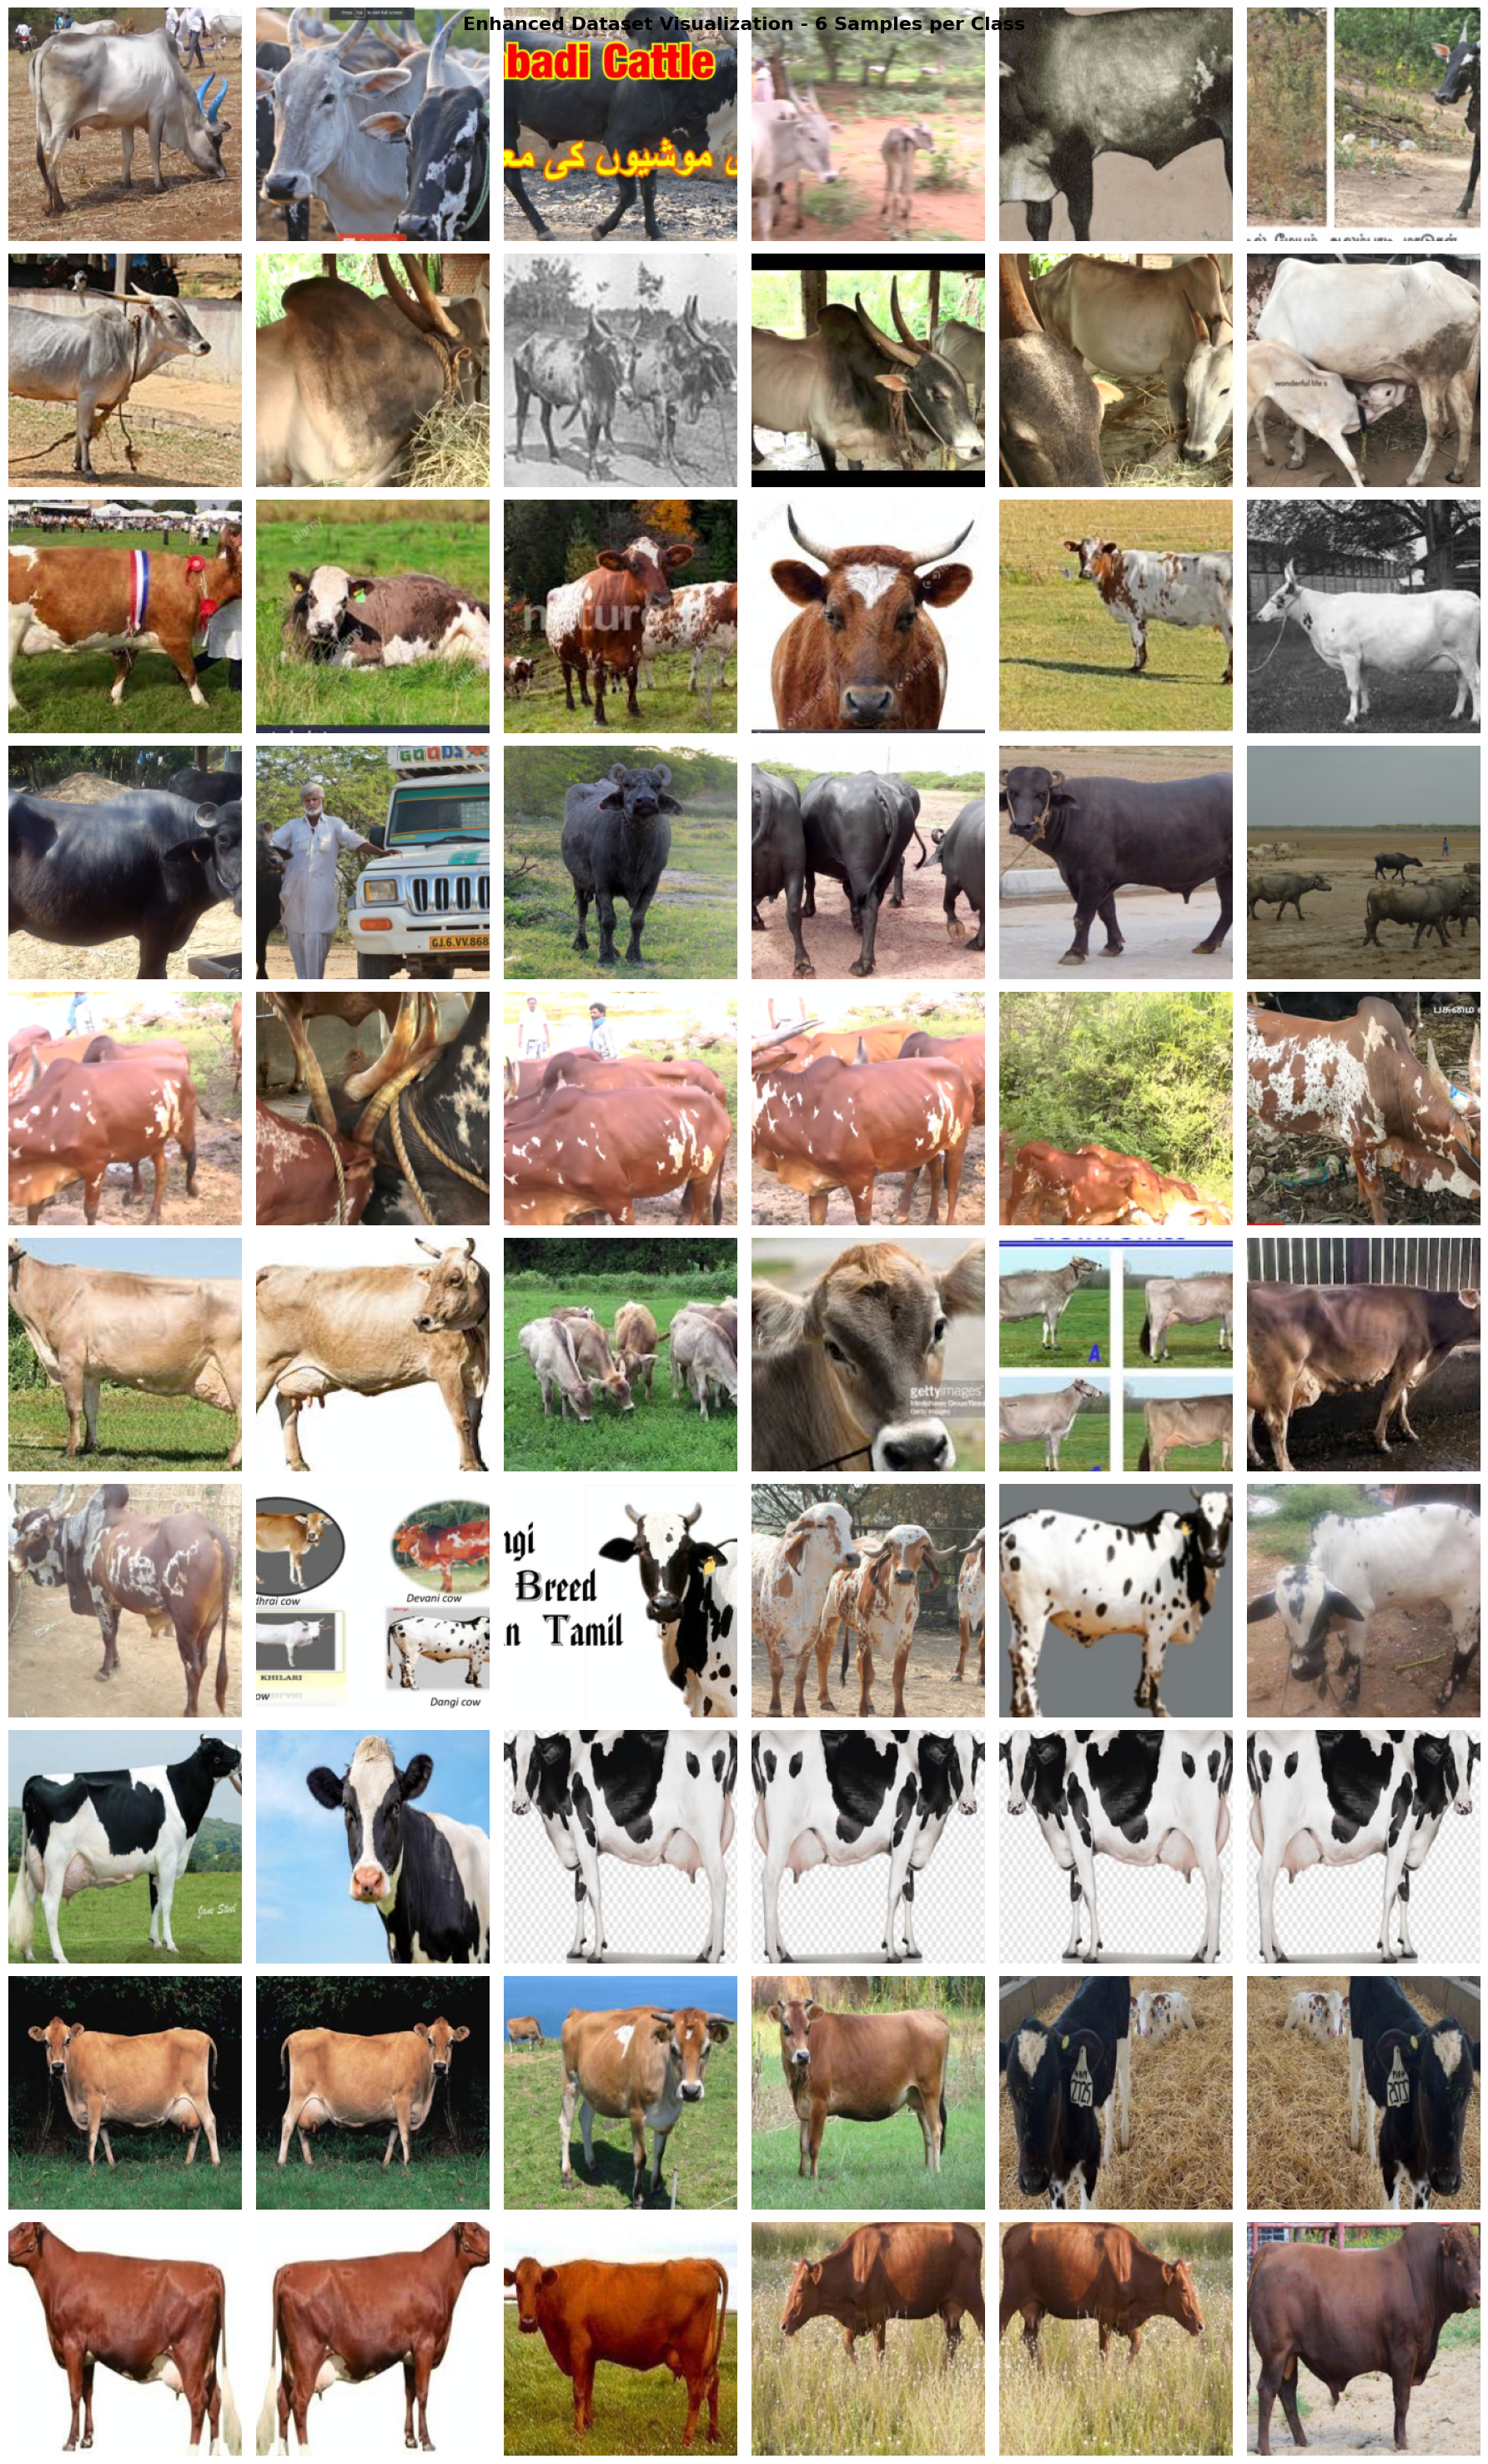

Enhanced dataset visualization saved at ./working/dataset_samples_enhanced.png


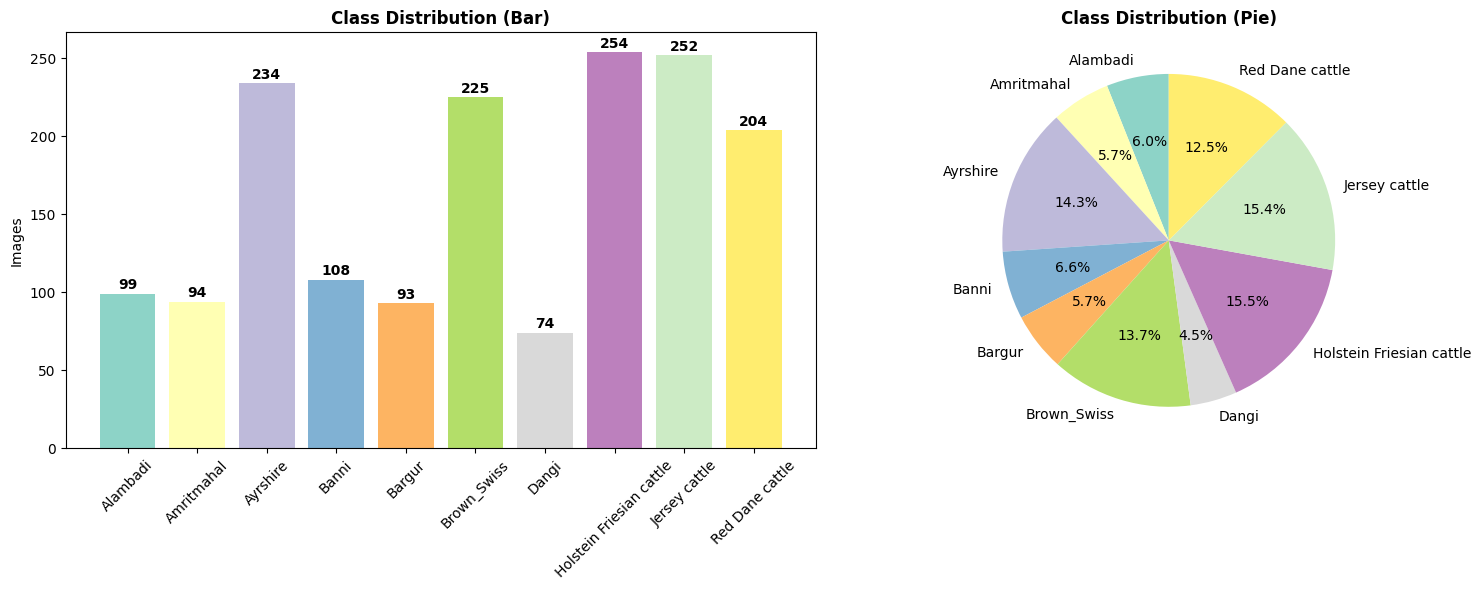

Class distribution visualization saved at ./working/class_distribution.png


In [13]:
def denorm(img_tensor):
    """Convert normalized CHW tensor -> HWC [0,1] numpy."""
    img = img_tensor.detach().cpu().numpy().transpose(1, 2, 0)
    img = np.clip(img * np.array([0.229, 0.224, 0.225]) +
                  np.array([0.485, 0.456, 0.406]), 0, 1)
    return img

def visualize_dataset_enhanced(dataset, class_names, save_path=f"{WORK_DIR}/dataset_samples_enhanced.png"):
    # show up to 6 samples per class from the dataset
    targets = dataset.targets  # valid for ImageFolder
    class_to_idx = dataset.class_to_idx

    ncols = 6
    fig, axes = plt.subplots(nrows=len(class_names), ncols=ncols, figsize=(18, 3*len(class_names)))
    fig.suptitle('Enhanced Dataset Visualization - 6 Samples per Class', fontsize=16, fontweight='bold')

    for i, cname in enumerate(class_names):
        cidx = class_to_idx[cname]
        sample_idxs = [idx for idx, t in enumerate(targets) if t == cidx][:ncols]
        for j, sidx in enumerate(sample_idxs):
            img, _ = dataset[sidx]
            axes[i, j].imshow(denorm(img))
            axes[i, j].axis('off')
            if j == 0:
                axes[i, j].set_ylabel(cname, fontsize=12, fontweight='bold', rotation=0, ha='right')

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight'); plt.show(); plt.close()
    print(f"Enhanced dataset visualization saved at {save_path}")

def plot_class_distribution(dataset, class_names, save_path=f"{WORK_DIR}/class_distribution.png"):
    counts = [dataset.targets.count(i) for i in range(len(class_names))]
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    bars = ax1.bar(class_names, counts, color=plt.cm.Set3(np.linspace(0, 1, len(class_names))))
    ax1.set_title('Class Distribution (Bar)', fontweight='bold')
    ax1.set_ylabel('Images'); ax1.tick_params(axis='x', rotation=45)
    for bar, c in zip(bars, counts):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height()+1, str(c), ha='center', va='bottom', fontweight='bold')

    ax2.pie(counts, labels=class_names, autopct='%1.1f%%', startangle=90,
            colors=plt.cm.Set3(np.linspace(0, 1, len(class_names))))
    ax2.set_title('Class Distribution (Pie)', fontweight='bold')

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight'); plt.show(); plt.close()
    print(f"Class distribution visualization saved at {save_path}")

visualize_dataset_enhanced(base_dataset, class_names)
plot_class_distribution(base_dataset, class_names)

# Splitting into Train,Test & Validation

In [14]:
from collections import defaultdict

def stratified_split_by_index(dataset, train_ratio=0.8, val_ratio=0.1, seed=SEED):
    rng = np.random.default_rng(seed)
    idxs_by_class = defaultdict(list)
    for idx, (_, label) in enumerate(dataset.samples):  # use sample labels (fast)
        idxs_by_class[label].append(idx)

    train_idx, val_idx, test_idx = [], [], []
    for lbl, idxs in idxs_by_class.items():
        idxs = np.array(idxs)
        rng.shuffle(idxs)
        n = len(idxs)
        n_train = int(n * train_ratio)
        n_val = int(n * val_ratio)
        train_idx.extend(idxs[:n_train].tolist())
        val_idx.extend(idxs[n_train:n_train + n_val].tolist())
        test_idx.extend(idxs[n_train + n_val:].tolist())
    return train_idx, val_idx, test_idx

train_indices, val_indices, test_indices = stratified_split_by_index(base_dataset)

# DataLoading

In [15]:
class SubsetWithTransform(Dataset):
    def __init__(self, base: datasets.ImageFolder, indices, transform):
        self.base = base
        self.indices = list(indices)
        self.transform = transform
        self.loader = base.loader
        self.samples = base.samples  # list of (path, target)
        self.targets = [self.samples[i][1] for i in self.indices]  # convenience

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        real_idx = self.indices[idx]
        path, target = self.samples[real_idx]
        img = self.loader(path)
        if self.transform is not None:
            img = self.transform(img)
        return img, target

train_dataset = SubsetWithTransform(base_dataset, train_indices, train_transform)
val_dataset   = SubsetWithTransform(base_dataset, val_indices,   test_transform)
test_dataset  = SubsetWithTransform(base_dataset, test_indices,  test_transform)

print(f"Dataset sizes - Train: {len(train_dataset)}, Validation: {len(val_dataset)}, Test: {len(test_dataset)}")

Dataset sizes - Train: 1307, Validation: 159, Test: 171


In [16]:
batch_size = 16
num_workers = max(2, os.cpu_count() // 2)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                          num_workers=num_workers, pin_memory=PIN, drop_last=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False,
                          num_workers=num_workers, pin_memory=PIN)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False,
                          num_workers=num_workers, pin_memory=PIN)

# Model Initialization

In [17]:
class EnhancedCattleClassifier(nn.Module):
    def __init__(self, num_classes=5, backbone='efficientnet'):
        super().__init__()
        self.backbone_name = backbone

        if backbone == 'efficientnet':
            weights = models.EfficientNet_B3_Weights.IMAGENET1K_V1
            self.backbone = models.efficientnet_b3(weights=weights)
            feature_dim = self.backbone.classifier[1].in_features
            self.backbone.classifier = nn.Identity()
        elif backbone == 'resnet':
            weights = models.ResNet50_Weights.IMAGENET1K_V2
            self.backbone = models.resnet50(weights=weights)
            feature_dim = self.backbone.fc.in_features
            self.backbone.fc = nn.Identity()
        else:
            raise ValueError("Unsupported backbone. Use 'efficientnet' or 'resnet'.")

        self.classifier = nn.Sequential(
            nn.Linear(feature_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

        # initialize only the classifier head
        for m in self.classifier.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        feats = self.backbone(x)
        if feats.ndim > 2:
            feats = torch.flatten(feats, 1)
        return self.classifier(feats)

    @torch.no_grad()
    def get_features(self, x):
        feats = self.backbone(x)
        if feats.ndim > 2:
            feats = torch.flatten(feats, 1)
        return feats

# Model Training

In [18]:
def plot_training_history(train_losses, val_losses, train_accs, val_accs):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    epochs = range(1, len(train_losses) + 1)

    ax1.plot(epochs, train_losses, label='Train'); ax1.plot(epochs, val_losses, label='Val')
    ax1.set_title('Loss'); ax1.legend(); ax1.grid(True, alpha=0.3)

    ax2.plot(epochs, train_accs, label='Train'); ax2.plot(epochs, val_accs, label='Val')
    ax2.set_title('Accuracy (%)'); ax2.legend(); ax2.grid(True, alpha=0.3)

    loss_diff = [abs(t - v) for t, v in zip(train_losses, val_losses)]
    ax3.plot(epochs, loss_diff); ax3.set_title('Loss Gap'); ax3.grid(True, alpha=0.3)

    acc_diff = [abs(t - v) for t, v in zip(train_accs, val_accs)]
    ax4.plot(epochs, acc_diff); ax4.set_title('Accuracy Gap'); ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    out = f"{WORK_DIR}/training_history.png"
    plt.savefig(out, dpi=300, bbox_inches='tight'); plt.show(); plt.close()

def train_enhanced_model(model, train_loader, val_loader, num_epochs=100, patience=15):
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2)
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-6)

    best_val_acc = 0.0
    epochs_no_improve = 0
    train_losses, val_losses, train_accs, val_accs = [], [], [], []

    start = time.time()
    for epoch in range(num_epochs):
        model.train()
        tr_loss, tr_correct, tr_total = 0.0, 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device, non_blocking=PIN), labels.to(device, non_blocking=PIN)

            optimizer.zero_grad(set_to_none=True)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            tr_loss += loss.item()
            tr_total += labels.size(0)
            tr_correct += (outputs.argmax(1) == labels).sum().item()

        model.eval()
        va_loss, va_correct, va_total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device, non_blocking=PIN), labels.to(device, non_blocking=PIN)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                va_loss += loss.item()
                va_total += labels.size(0)
                va_correct += (outputs.argmax(1) == labels).sum().item()

        tr_loss /= len(train_loader)
        va_loss /= len(val_loader)
        tr_acc = 100.0 * tr_correct / tr_total
        va_acc = 100.0 * va_correct / va_total

        train_losses.append(tr_loss); val_losses.append(va_loss)
        train_accs.append(tr_acc);    val_accs.append(va_acc)

        scheduler.step(epoch + 1)
        lr = optimizer.param_groups[0]['lr']

        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss {tr_loss:.4f} Acc {tr_acc:.2f}% | "
              f"Val Loss {va_loss:.4f} Acc {va_acc:.2f}% | LR {lr:.6f}")

        if va_acc > best_val_acc:
            best_val_acc = va_acc
            epochs_no_improve = 0
            torch.save({
                "epoch": epoch + 1,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "val_acc": va_acc
            }, f"{WORK_DIR}/best_enhanced_model.pth")
            print(f"  -> New best model saved (Val Acc {va_acc:.2f}%)")
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    print(f"Total training time: {time.time()-start:.2f}s")
    # Load best
    ckpt = torch.load(f"{WORK_DIR}/best_enhanced_model.pth", map_location=device)
    model.load_state_dict(ckpt["model_state_dict"])

    plot_training_history(train_losses, val_losses, train_accs, val_accs)
    return model, train_losses, val_losses, train_accs, val_accs

In [19]:
def plot_confusion_matrices(true_labels, pred_labels, class_names):
    cm = confusion_matrix(true_labels, pred_labels)
    cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    ax1.set_title('Confusion Matrix (Counts)', fontweight='bold')
    ax1.set_xlabel('Predicted'); ax1.set_ylabel('True')

    sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='Reds', ax=ax2,
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Percentage'})
    ax2.set_title('Confusion Matrix (Percent)', fontweight='bold')
    ax2.set_xlabel('Predicted'); ax2.set_ylabel('True')

    plt.tight_layout()
    plt.savefig(f"{WORK_DIR}/confusion_matrices.png", dpi=300, bbox_inches='tight'); plt.show(); plt.close()

def plot_roc_and_pr_curves(true_labels, pred_probs, class_names):
    from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
    from sklearn.preprocessing import label_binarize

    y_true = label_binarize(true_labels, classes=list(range(len(class_names))))
    probs = np.array(pred_probs)
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

    colors = plt.cm.Set1(np.linspace(0, 1, len(class_names)))
    auc_scores, ap_scores = [], []

    # ROC
    for i, (cname, col) in enumerate(zip(class_names, colors)):
        fpr, tpr, _ = roc_curve(y_true[:, i], probs[:, i])
        roc_auc = auc(fpr, tpr)
        auc_scores.append(roc_auc)
        ax1.plot(fpr, tpr, label=f'{cname} (AUC {roc_auc:.3f})')
    ax1.plot([0, 1], [0, 1], 'k--', linewidth=1)
    ax1.set_title('ROC (OvR)'); ax1.set_xlabel('FPR'); ax1.set_ylabel('TPR'); ax1.legend(); ax1.grid(True, alpha=0.3)

    # PR
    for i, (cname, col) in enumerate(zip(class_names, colors)):
        precision, recall, _ = precision_recall_curve(y_true[:, i], probs[:, i])
        ap = average_precision_score(y_true[:, i], probs[:, i])
        ap_scores.append(ap)
        ax2.plot(recall, precision, label=f'{cname} (AP {ap:.3f})')
    ax2.set_title('Precision-Recall'); ax2.set_xlabel('Recall'); ax2.set_ylabel('Precision'); ax2.legend(); ax2.grid(True, alpha=0.3)

    bars = ax3.bar(class_names, auc_scores)
    ax3.set_title('AUC by Class'); ax3.set_ylim(0, 1); ax3.tick_params(axis='x', rotation=45)
    for b, s in zip(bars, auc_scores): ax3.text(b.get_x()+b.get_width()/2, b.get_height()+0.01, f'{s:.3f}', ha='center')

    bars = ax4.bar(class_names, ap_scores)
    ax4.set_title('Average Precision by Class'); ax4.set_ylim(0, 1); ax4.tick_params(axis='x', rotation=45)
    for b, s in zip(bars, ap_scores): ax4.text(b.get_x()+b.get_width()/2, b.get_height()+0.01, f'{s:.3f}', ha='center')

    plt.tight_layout()
    plt.savefig(f"{WORK_DIR}/roc_pr_curves.png", dpi=300, bbox_inches='tight'); plt.show(); plt.close()

def plot_per_class_metrics(true_labels, pred_labels, class_names):
    from sklearn.metrics import precision_recall_fscore_support
    precision, recall, f1, support = precision_recall_fscore_support(true_labels, pred_labels, average=None, zero_division=0)
    cm = confusion_matrix(true_labels, pred_labels)
    per_acc = cm.diagonal() / cm.sum(axis=1)

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    x = np.arange(len(class_names)); w = 0.2

    ax1.bar(x - 1.5*w, precision, w, label='Precision')
    ax1.bar(x - 0.5*w, recall,   w, label='Recall')
    ax1.bar(x + 0.5*w, f1,       w, label='F1')
    ax1.bar(x + 1.5*w, per_acc,  w, label='Accuracy')
    ax1.set_title('Per-Class Metrics', fontweight='bold'); ax1.set_xticks(x); ax1.set_xticklabels(class_names, rotation=45); ax1.set_ylim(0, 1); ax1.legend(); ax1.grid(True, alpha=0.3)

    # Precision heat
    prec_mat = precision.reshape(1, -1)
    im = ax2.imshow(prec_mat, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
    ax2.set_xticks(range(len(class_names))); ax2.set_xticklabels(class_names, rotation=45); ax2.set_yticks([0]); ax2.set_yticklabels(['Precision'])
    for i, v in enumerate(precision): ax2.text(i, 0, f'{v:.3f}', ha='center', va='center', fontweight='bold')
    ax2.set_title('Precision Heatmap', fontweight='bold')

    bars = ax3.bar(class_names, support)
    ax3.set_title('Support'); ax3.tick_params(axis='x', rotation=45)
    for b, s in zip(bars, support): ax3.text(b.get_x()+b.get_width()/2, b.get_height()+0.5, str(s), ha='center')

    # Radar-like polar plot (compact)
    angles = np.linspace(0, 2*np.pi, len(class_names), endpoint=False).tolist()
    angles += angles[:1]
    ax4 = plt.subplot(2,2,4, projection='polar')
    def _close(vals): return np.concatenate([vals, vals[:1]])
    for name, vals in [('Precision', precision), ('Recall', recall), ('F1', f1), ('Acc', per_acc)]:
        ax4.plot(angles, _close(vals), linewidth=2, label=name)
        ax4.fill(angles, _close(vals), alpha=0.15)
    ax4.set_xticks(angles[:-1]); ax4.set_xticklabels(class_names); ax4.set_ylim(0, 1); ax4.set_title('Polar Metrics', pad=20); ax4.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))

    plt.tight_layout()
    plt.savefig(f"{WORK_DIR}/per_class_metrics.png", dpi=300, bbox_inches='tight'); plt.show(); plt.close()

def evaluate_comprehensive(model, test_loader, class_names):
    model.eval()
    all_preds, all_labels, all_probs = [], [], []
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device, non_blocking=PIN)
            y = y.to(device, non_blocking=PIN)
            out = model(x)
            prob = torch.softmax(out, dim=1)
            all_preds.extend(out.argmax(1).cpu().numpy())
            all_labels.extend(y.cpu().numpy())
            all_probs.extend(prob.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    rec  = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    f1   = f1_score(all_labels, all_preds, average='macro', zero_division=0)

    print("="*60)
    print("COMPREHENSIVE EVALUATION RESULTS")
    print("="*60)
    print(f"Overall Accuracy: {acc*100:.2f}%")
    print(f"Macro Precision: {prec:.4f}")
    print(f"Macro Recall:    {rec:.4f}")
    print(f"Macro F1 Score:  {f1:.4f}")
    print("\nDetailed Classification Report:\n")
    print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))

    plot_confusion_matrices(all_labels, all_preds, class_names)
    plot_roc_and_pr_curves(all_labels, all_probs, class_names)
    plot_per_class_metrics(all_labels, all_preds, class_names)
    return acc, prec, rec, f1, np.array(all_labels), np.array(all_preds), np.array(all_probs)

# Feature Space Viz (PCA + t-SNE)

In [20]:
def visualize_features_tsne_pca(model, loader, class_names, max_samples=1000):
    model.eval()
    feats_list, labs_list = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device, non_blocking=PIN)
            f = model.get_features(x).cpu().numpy()
            feats_list.append(f); labs_list.append(y.numpy())
            if sum(len(a) for a in labs_list) >= max_samples:
                break

    feats = np.vstack(feats_list)[:max_samples]
    labs  = np.concatenate(labs_list)[:max_samples]

    pca = PCA(n_components=min(50, feats.shape[1]), random_state=SEED)
    feats_pca = pca.fit_transform(feats)

    tsne = TSNE(n_components=2, random_state=SEED, perplexity=30, n_iter=1000, init='pca')
    feats_tsne = tsne.fit_transform(feats_pca)

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    colors = plt.cm.Set1(np.linspace(0, 1, len(class_names)))

    for i, (cname, col) in enumerate(zip(class_names, colors)):
        mask = labs == i
        ax1.scatter(feats_tsne[mask, 0], feats_tsne[mask, 1], label=cname, alpha=0.6, s=30)
    ax1.set_title('t-SNE of Features'); ax1.legend(); ax1.grid(True, alpha=0.3)

    for i, (cname, col) in enumerate(zip(class_names, colors)):
        mask = labs == i
        ax2.scatter(feats_pca[mask, 0], feats_pca[mask, 1], label=cname, alpha=0.6, s=30)
    ax2.set_title('PCA (first 2)'); ax2.legend(); ax2.grid(True, alpha=0.3)

    evr = pca.explained_variance_ratio_[:10]
    ax3.bar(range(1, len(evr)+1), evr); ax3.set_title('PCA Explained Variance (Top 10)'); ax3.grid(True, alpha=0.3)

    cumsum = np.cumsum(pca.explained_variance_ratio_)
    ax4.plot(range(1, len(cumsum)+1), cumsum); ax4.axhline(0.95, ls='--', c='r', label='95%')
    ax4.set_title('Cumulative Explained Variance'); ax4.legend(); ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    out = f"{WORK_DIR}/feature_analysis.png"
    plt.savefig(out, dpi=300, bbox_inches='tight'); plt.show(); plt.close()
    return feats, labs

In [21]:
def grid_from_feature_maps(tensor, max_channels=16, normalize=True):
    """tensor: (C,H,W) -> grid image"""
    C, H, W = tensor.shape
    k = min(max_channels, C)
    idxs = np.linspace(0, C-1, k, dtype=int)
    maps = tensor[idxs].detach().cpu().numpy()

    # normalize each map to [0,1]
    if normalize:
        maps = (maps - maps.min(axis=(1,2), keepdims=True)) / (maps.ptp(axis=(1,2), keepdims=True) + 1e-6)

    cols = int(np.ceil(np.sqrt(k)))
    rows = int(np.ceil(k / cols))
    gap = 2
    grid = np.ones((rows*H + (rows-1)*gap, cols*W + (cols-1)*gap))

    i = 0
    for r in range(rows):
        for c in range(cols):
            if i >= k: break
            y0 = r*(H+gap); x0 = c*(W+gap)
            grid[y0:y0+H, x0:x0+W] = maps[i]
            i += 1
    return grid

@torch.no_grad()
def visualize_enhanced_feature_maps(model, image, class_name, save_prefix="sample"):
    """
    Captures feature maps from several backbone stages and saves montages.
    Works with EfficientNet (features Sequential) and ResNet (layer1..4).
    """
    model.eval()
    image = image.unsqueeze(0).to(device, non_blocking=PIN)

    activations = {}
    hooks = []

    def save_act(name):
        def fn(_m, _i, o):
            activations[name] = o.detach()
        return fn

    layer_names = []
    if hasattr(model.backbone, "features"):  # EfficientNet
        feats = model.backbone.features
        candidate_idx = list(range(len(feats)))  # capture many; we’ll sample a few
        # pick representative blocks (early/mid/late) safely within range
        pick = sorted(set([0, 1, 2, 3, 4, 5, 6, len(feats)-2, len(feats)-1]))
        pick = [i for i in pick if 0 <= i < len(feats)]
        for i in pick:
            name = f"features_{i}"
            layer_names.append(name)
            hooks.append(feats[i].register_forward_hook(save_act(name)))
    else:  # ResNet
        picks = [("layer1", model.backbone.layer1),
                 ("layer2", model.backbone.layer2),
                 ("layer3", model.backbone.layer3),
                 ("layer4", model.backbone.layer4)]
        for n, m in picks:
            layer_names.append(n)
            hooks.append(m.register_forward_hook(save_act(n)))

    _ = model(image)

    for h in hooks: h.remove()

    # Save montages
    paths = []
    for name in layer_names:
        if name not in activations: continue
        feat = activations[name][0]  # (C,H,W)
        # Adaptive to manageable size for display
        if feat.shape[-1] > 112:
            feat_small = nn.functional.interpolate(activations[name], size=(112,112), mode='bilinear', align_corners=False)[0]
        else:
            feat_small = feat
        grid = grid_from_feature_maps(feat_small, max_channels=16)
        plt.figure(figsize=(10, 10))
        plt.imshow(grid, cmap='viridis'); plt.axis('off')
        plt.title(f"{name} | {class_name}")
        out = f"{WORK_DIR}/{save_prefix}_{name}_feature_maps.png"
        plt.savefig(out, dpi=300, bbox_inches='tight'); plt.show(); plt.close()
        paths.append(out)
    return paths

In [22]:
class GradCAM:
    """
    Stable Grad-CAM using forward+full_backward hooks.
    """
    def __init__(self, model, target_layer_name):
        self.model = model
        self.model.eval()
        self.gradients = None
        self.activations = None

        modules = dict(self.model.named_modules())
        if target_layer_name not in modules:
            raise ValueError(f"Layer '{target_layer_name}' not found in model.")
        self.target_layer = modules[target_layer_name]
        self.fh = self.target_layer.register_forward_hook(self._save_activation)
        self.bh = self.target_layer.register_full_backward_hook(self._save_gradient)

    def _save_activation(self, module, inp, out):
        self.activations = out.detach()

    def _save_gradient(self, module, grad_in, grad_out):
        self.gradients = grad_out[0].detach()

    def __call__(self, image_tensor, class_idx):
        self.gradients = None
        self.activations = None

        img = image_tensor.unsqueeze(0).to(device, non_blocking=PIN).requires_grad_(True)
        out = self.model(img)
        score = out[0, class_idx]
        self.model.zero_grad(set_to_none=True)
        score.backward(retain_graph=True)

        if self.gradients is None or self.activations is None:
            return None

        weights = self.gradients.mean(dim=(2, 3), keepdim=True)  # GAP over H,W
        cam = (weights * self.activations).sum(dim=1, keepdim=True)
        cam = torch.relu(cam)
        cam = cam / (cam.max() + 1e-8)
        cam = nn.functional.interpolate(cam, size=(224, 224), mode='bilinear', align_corners=False)
        return cam.squeeze(0).squeeze(0).detach().cpu().numpy()

    def close(self):
        if hasattr(self, "fh") and self.fh is not None: self.fh.remove()
        if hasattr(self, "bh") and self.bh is not None: self.bh.remove()

def analyze_model_comprehensive(model, loader, class_names, num_samples=5):
    # collect first N images from test loader
    samples = []
    for imgs, labels in loader:
        for i in range(imgs.size(0)):
            samples.append((imgs[i], labels[i].item()))
            if len(samples) >= num_samples: break
        if len(samples) >= num_samples: break

    # choose target layer for Grad-CAM
    target_layer_name = "backbone.features.7" if hasattr(model.backbone, "features") else "backbone.layer4"
    cam = GradCAM(model, target_layer_name)

    for idx, (img_t, y) in enumerate(samples, 1):
        img_np = denorm(img_t)
        with torch.no_grad():
            prob = torch.softmax(model(img_t.unsqueeze(0).to(device)), dim=1)[0].cpu().numpy()
            y_pred = int(np.argmax(prob))

        fig = plt.figure(figsize=(20, 12))

        # Original
        ax = plt.subplot(2, 4, 1); ax.imshow(img_np); ax.axis('off')
        ax.set_title(f'Original\nTrue: {class_names[y]}\nPred: {class_names[y_pred]}', fontweight='bold')

        # Probabilities
        ax = plt.subplot(2, 4, 2)
        bars = ax.bar(range(len(class_names)), prob, color=plt.cm.Set3(np.linspace(0,1,len(class_names))))
        bars[y_pred].set_color('red'); bars[y].set_edgecolor('green'); bars[y].set_linewidth(3)
        ax.set_xticks(range(len(class_names))); ax.set_xticklabels(class_names, rotation=45)
        ax.set_title('Prediction Probabilities', fontweight='bold')

        # Grad-CAM (pred class)
        ax = plt.subplot(2, 4, 3)
        cam_map = cam(img_t.clone(), y_pred)
        ax.imshow(img_np)
        if cam_map is not None:
            ax.imshow(cam_map, cmap='jet', alpha=0.4)
            ax.set_title('Grad-CAM (Pred Class)', fontweight='bold')
        else:
            ax.set_title('Grad-CAM (N/A)', fontweight='bold')
        ax.axis('off')

        # Feature vector (first 100 dims)
        ax = plt.subplot(2, 4, 4)
        with torch.no_grad():
            fv = model.get_features(img_t.unsqueeze(0).to(device)).squeeze(0).cpu().numpy()
        ax.plot(fv[:100]); ax.set_title('Feature Vector (first 100)'); ax.grid(True, alpha=0.3)

        # Confidence / Entropy
        ax = plt.subplot(2, 4, 5)
        confidence = float(prob[y_pred])
        p = prob + 1e-8
        entropy = float(-(p*np.log(p)).sum()/np.log(len(class_names)))
        metrics = ['Confidence', '1-Entropy', 'Correct?']
        values = [confidence, 1.0 - entropy, 1.0 if y == y_pred else 0.0]
        cols = ['green' if v > 0.8 else 'orange' if v > 0.6 else 'red' for v in values]
        bb = ax.bar(metrics, values, color=cols); ax.set_ylim(0,1); ax.set_title('Prediction Quality', fontweight='bold')
        for b, v in zip(bb, values): ax.text(b.get_x()+b.get_width()/2, v+0.02, f'{v:.3f}', ha='center')

        # Top-3
        ax = plt.subplot(2, 4, 6)
        top3_idx = np.argsort(-prob)[:3]; top3_vals = prob[top3_idx]
        bb = ax.bar(range(3), top3_vals, color=['gold','silver','#CD7F32'])
        ax.set_xticks(range(3)); ax.set_xticklabels([class_names[i] for i in top3_idx], rotation=45)
        ax.set_ylim(0,1); ax.set_title('Top-3 Predictions', fontweight='bold')
        for b, v in zip(bb, top3_vals): ax.text(b.get_x()+b.get_width()/2, v+0.01, f'{v:.3f}', ha='center')

        # Correct/Incorrect pie
        ax = plt.subplot(2, 4, 7)
        ax.pie([1,0] if y==y_pred else [0,1], labels=['Correct','Incorrect'], colors=['green','red'], autopct='%1.0f%%', startangle=90)
        ax.set_title('Prediction Result', fontweight='bold')

        # Input grad importance
        ax = plt.subplot(2, 4, 8)
        img_var = img_t.unsqueeze(0).to(device).requires_grad_(True)
        out = model(img_var)
        target = out[0, y_pred]
        model.zero_grad(set_to_none=True)
        target.backward()
        imp = img_var.grad.detach().abs().mean(dim=1)[0].cpu().numpy()
        ax.imshow(imp, cmap='hot'); ax.axis('off'); ax.set_title('Input Importance (grad)', fontweight='bold')

        plt.suptitle(f'Comprehensive Analysis - Sample {idx}', fontsize=16, fontweight='bold')
        outp = f"{WORK_DIR}/comprehensive_analysis_sample_{idx}.png"
        plt.savefig(outp, dpi=300, bbox_inches='tight'); plt.show(); plt.close()

    cam.close()

In [25]:
class EnhancedCattleClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        # Use a stable pretrained backbone
        weights = models.EfficientNet_B0_Weights.IMAGENET1K_V1
        self.backbone = models.efficientnet_b0(weights=weights)

        # Replace classifier with identity to extract features
        feature_dim = self.backbone.classifier[1].in_features
        self.backbone.classifier = nn.Identity()

        # New custom classifier head
        self.classifier = nn.Sequential(
            nn.Linear(feature_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.classifier(x)
        return x


In [ ]:
print("Saving per-layer feature maps for a few test samples...")
# pick one representative sample per class (if possible), else first N
picked = {}
test_iter = iter(test_loader)
while len(picked) < min(len(class_names), 4):  # limit to 4 to keep it light
    try:
        xb, yb = next(test_iter)
    except StopIteration:
        break
    for i in range(len(yb)):
        c = int(yb[i].item())
        if c not in picked:
            picked[c] = xb[i]
        if len(picked) >= min(len(class_names), 4):
            break

for c, img in picked.items():
    _paths = visualize_enhanced_feature_maps(trained_model, img, class_names[c], save_prefix=f"example_{class_names[c]}")

Saving per-layer feature maps for a few test samples...


In [ ]:
print("Performing comprehensive model analysis on a few samples (with Grad-CAM)...")
analyze_model_comprehensive(trained_model, test_loader, class_names)

# Save final model
torch.save({
    'model_state_dict': trained_model.state_dict(),
    'class_names': class_names,
    'num_classes': num_classes,
    'accuracy': acc,
    'architecture': f'Enhanced{model.backbone_name.title()}'
}, f"{WORK_DIR}/final_enhanced_cattle_classifier.pth")

print("="*60)
print("TRAINING AND EVALUATION COMPLETED!")
print(f"Final Test Accuracy: {acc*100:.2f}%")
print(f"Target Accuracy: 95.00%")
print(f"Achievement: {'✅ TARGET REACHED!' if acc >= 0.95 else '❌ TARGET NOT REACHED'}")
print("="*60)
print("All visualizations and model saved successfully!")
print("Generated files:")
print("- /kaggle/working/dataset_samples_enhanced.png")
print("- /kaggle/working/class_distribution.png")
print("- /kaggle/working/training_history.png")
print("- /kaggle/working/confusion_matrices.png")
print("- /kaggle/working/roc_pr_curves.png")
print("- /kaggle/working/per_class_metrics.png")
print("- /kaggle/working/feature_analysis.png")
print("- /kaggle/working/comprehensive_analysis_sample_X.png (X = 1..5)")
print("- /kaggle/working/example_<CLASS>_features_*.png (per-layer feature maps)")
print("- /kaggle/working/final_enhanced_cattle_classifier.pth")

In [ ]:
torch.save(model.state_dict(), "model/cattle_breed_model.pth")
